# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sb
import datetime
import multiprocessing
from itertools import chain
import xlwings as xw
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics as skmetrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import LancasterStemmer

import tensorflow as tf
from tensorflow import keras
from keras.metrics import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.layers import InputLayer
# from tensorflow.keras import losses
# from tensorflow.keras.regularizers import L2
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.layers import TextVectorization

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

2023-05-08 10:55:41.343311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [145]:
cores = multiprocessing.cpu_count()

START = datetime.date(2010,10,1)
END = datetime.date(2010,12,31)

# Dataloading and Preprocessing

In [3]:
df1 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/logon.csv')
df2 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/device.csv')
df3 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/email.csv')
df4 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/file.csv')
df5 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/http.csv')
ans = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/answers/answers.csv')


In [4]:
ldap = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/ldap/2010-10.csv')

In [5]:
df3['activity'] = "email"
df4['activity'] = "file"
df5['activity'] = "http"

Dropping all except the text data from web browsing.

In [6]:
df3 = df3.drop(columns={'content'})
df4 = df4.drop(columns={'content'})

In [7]:
df_merged = pd.concat([df1, df2, df3, df4, df5])
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['day_date'] = pd.to_datetime(df_merged['date']).dt.date

In [146]:
df_time_range = df_merged[((df_merged['day_date'] >= START) & (df_merged['day_date'] <= END))]

In [147]:
df_time_range['label'] = 'normal'
df_time_range.loc[df_time_range['id'].isin(ans['id']),['label']] = 'abnormal'

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/1036657486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_range['label'] = 'normal'


In [148]:
#userEvents = df_time_range.loc[(df_time_range['user'] == 'IJM0776')]
userEvents = df_time_range
userEvents['activityMinute'] = userEvents['date'].apply(lambda s: (s - s.replace(hour=0, minute=0, second=0, microsecond=0)).seconds)
userEvents['activityMinute'] = userEvents['activityMinute'].apply(lambda s: (s/60))

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/3009779728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['activityMinute'] = userEvents['date'].apply(lambda s: (s - s.replace(hour=0, minute=0, second=0, microsecond=0)).seconds)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/3009779728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['activityMinute'] = userEvents['activityMinute'].apply(lambda s: (s/60))


In [206]:
userEvents

,id,date,user,pc,activity,to,cc,bcc,from,size,attachments,filename,url,content,day_date,label,activityMinute,tokenized
493333,{B3G1-V9OL66EH-8410IJIY},2010-10-01 00:08:45,IBB0359,PC-9140,Logon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2010-10-01,normal,8.750000,
493334,{U8I4-I5RG02SY-5107ODAD},2010-10-01 00:13:15,WPR0368,PC-3372,Logon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2010-10-01,normal,13.250000,
493335,{Q9A1-H5PT97NT-9067IHAZ},2010-10-01 00:19:36,KSP0357,PC-9787,Logon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2010-10-01,normal,19.600000,
493336,{E7M3-Z0KQ06ME-3584HBKI},2010-10-01 00:19:43,BKW0374,PC-2511,Logon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2010-10-01,normal,19.716667,
493337,{Z7M8-T1JN33IE-3358BJDQ},2010-10-01 00:27:13,IBB0359,PC-9140,Logoff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2010-10-01,normal,27.216667,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21178325,{N7Y7-M0KU60QE-8505SBHF},2010-12-31 19:11:15,AMW0392,PC-6163,http,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://hilton.com/Peter_Heywood/heywoods/zlfgr...,began king canterbury places after where south...,2010-12-31,normal,1151.250000,beg canterbury plac sou writ battl origin mode...
21178326,{Q9K7-S2RG02ME-7503FJSK},2010-12-31 19:12:24,AMW0392,PC-6163,http,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://abcnews.go.com/Nathaniel_Parker_Willis/...,kept omits licence golden man ill these forced...,2010-12-31,normal,1152.400000,omit gold man forc milit vog complet list born...
21178327,{P8O5-W0XH10HB-7035OPBG},2010-12-31 19:17:34,JDC0030,PC-0246,http,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://adobe.com/Sinestro_Corps_War/ganthet/fr...,latter burying discovered somewhat instability...,2010-12-31,normal,1157.566667,discov inst peasco maj ii princip ground colle...
21178328,{C7L5-F5CP14DP-6888STLU},2010-12-31 19:18:13,JDC0030,PC-0246,http,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://adobe.com/Sinestro_Corps_War/ganthet/fr...,shortage ketl fajada across five berms indicat...,2010-12-31,normal,1158.216667,short ketl fajad fiv berm visit effort abl ter...


# NLP Prep

In [149]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
def prepare_text(pretext):
    tokens = word_tokenize(pretext, language="english", preserve_line=True)
    token_tag = pos_tag(tokens)
    include_tags = ['VBN', 'VBD', 'JJ', 'JJS', 'JJR', 'CD', 'NN', 'NNS', 'NNP', 'NNPS']
    filtered_tokens = (tok for tok, tag in token_tag if tag in include_tags)    
    stemmed_tokens = (lancaster.stem(tok) for tok in filtered_tokens)
    lemmed_words = (lemmatizer.lemmatize(tok) for tok in stemmed_tokens)
    lower_words = [str.lower(tok) for tok in lemmed_words]
    joined = " ".join(lower_words)
    return(joined)
lancaster = LancasterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [150]:
userEvents['content'].fillna('', inplace=True)
userEvents['tokenized'] = userEvents['content'].apply(prepare_text)
nltk.download('stopwords')
stops = set(stopwords.words('english'))

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/3075726431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['content'].fillna('', inplace=True)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/3075726431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['tokenized'] = userEvents['content'].apply(prepare_text)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# INDIVIDUAL ANALYSIS

In [151]:
dates = userEvents['day_date']
dates = dates.unique()

In [152]:
INTERVAL=1440
dateActivity = []
for d in dates:
    dayEvents = userEvents.loc[(userEvents['day_date'] == d)]
    users = dayEvents['user']
    users = users.unique()
    for u in users:
        label = 0
        dailyActivityMatrix = []
        userdf = dayEvents.loc[(dayEvents['user'] == u)]
        for i in range(0, 1440, INTERVAL):
            bin_Events = userdf.loc[(userdf['activityMinute'] >= i ) & (userdf['activityMinute'] < (i + INTERVAL))]
            connect_count = bin_Events[bin_Events['activity'] == 'Connect'].shape[0]
            disconnect_count = bin_Events[bin_Events['activity'] == 'Disconnect'].shape[0]
            login_count = bin_Events[bin_Events['activity'] == 'Logon'].shape[0]
            logout_count = bin_Events[bin_Events['activity'] == 'Logoff'].shape[0]
            email_count = bin_Events[bin_Events['activity'] == 'email'].shape[0]
            file_count = bin_Events[bin_Events['activity'] == 'file'].shape[0]
            http_count = bin_Events[bin_Events['activity'] == 'http'].shape[0]
            intervalList = [connect_count, login_count, logout_count, email_count, file_count, http_count, disconnect_count]
            dailyActivityMatrix.append(intervalList)
            if (bin_Events[(bin_Events['label'] == 'abnormal')].shape[0] > 0): label = 1
            text = ' '.join(bin_Events['tokenized'])
        dateActivity.append([d, u, dailyActivityMatrix, text, label])

In [187]:
final = pd.DataFrame(dateActivity, columns=['date', 'user', 'dailyActivityMatrix', 'text', 'label'])
final['dailyActivityMatrix'] = final['dailyActivityMatrix'].apply(lambda y: (list(chain.from_iterable(y))))
df_temp = pd.DataFrame(final['dailyActivityMatrix'].tolist())
df_final = pd.DataFrame()
df_final = final.join(df_temp)

In [188]:
df_final['text'] = df_final['text'].replace(r'\s+', ' ', regex=True)

In [189]:
users = df_final['user']
users = users.unique()

DAYS_PAST = 1
indPastActivity = pd.DataFrame()
for u in users:
    userevents = final.loc[(final['user'] == u)]
    vector_activity = userevents.loc[:, ['dailyActivityMatrix']]
    vector_past_activity = vector_activity.shift(DAYS_PAST)
    vector_past_activity = vector_past_activity.rename(columns={'dailyActivityMatrix':'dailyActivityMatrixPast'})

    events = userevents.filter(['user', 'date'])
    events = events.join(vector_past_activity)
    indPastActivity = pd.concat([indPastActivity, events])

In [190]:
df_final = pd.merge(df_final, indPastActivity, on=['user', 'date'], how='left')
df_final = df_final[df_final['dailyActivityMatrixPast'].notna()]

In [191]:
def euclidean(v1, v2):
    return sum((p-q)**2 for p, q in zip(v1, v2)) ** .5

In [192]:
distances = []
for i in range(0, df_final.shape[0]):
    distances.append(euclidean(df_final.iloc[i]['dailyActivityMatrix'], df_final.iloc[i]['dailyActivityMatrixPast']))
df_final['ind2past'] = distances

# MERGE INDIVIDUAL AND GROUP

In [193]:
#Bringing in the LDAP and Group Data
ldap = ldap.rename(columns={'user_id': 'user'})
df_final = pd.merge(df_final, ldap, on='user', how='left')

Clean up

In [194]:
df_final.dropna(how='any', inplace=True)

In [166]:
# label_encoder = LabelEncoder()
# df_final['userid'] = label_encoder.fit_transform(df_final['user'])

# Methods

In [195]:
df = df_final.copy()

In [196]:
print("Number of malicious records: ", df_final['label'].value_counts()[1])
print("Number of normal records: ", df_final['label'].value_counts()[0])

Number of malicious records:  201
Number of normal records:  48410


In [197]:
X = df.drop(columns=['label'])

In [198]:
y = df['label']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [208]:
role = X_train['role']
role = role.unique()

In [209]:
role

array(['Technician', 'Salesman', 'MechanicalEngineer', 'SecurityGuard',
       'ProductionLineWorker', 'ElectricalEngineer', 'Mathematician',
       'ITAdmin', 'Scientist', 'LabManager', 'SystemsEngineer',
       'SoftwareEngineer', 'ComputerProgrammer', 'ComputerScientist',
       'Physicist', 'FieldServiceEngineer', 'AdministrativeAssistant',
       'MaterialsEngineer', 'HardwareEngineer', 'Manager', 'TestEngineer',
       'AssemblySupervisor', 'ChiefEngineer'], dtype=object)

In [210]:
dates = X_train['date']
dates = dates.unique()

In [207]:
X_train

,date,user,dailyActivityMatrix,text,0,1,2,3,4,5,...,dailyActivityMatrixPast,ind2past,employee_name,email,role,business_unit,functional_unit,department,team,supervisor
7624,2010-10-13,JZD0888,"[0, 1, 1, 3, 0, 29, 0]",born 7 lost vow jackson car stor 250000 micha...,0,1,1,3,0,29,...,"[0, 1, 1, 3, 0, 29, 0]",0.00000,Jane Zia Day,Jane.Zia.Day@dtaa.com,Technician,1.0,5 - SalesAndMarketing,3 - FieldService,5 - RegionalFieldService,Blythe Veda Cooke
34161,2010-11-23,SVS0871,"[0, 2, 2, 15, 0, 162, 0]",memb hospit 2005 charg degr way 20 interest n...,0,2,2,15,0,162,...,"[0, 3, 2, 15, 0, 162, 0]",1.00000,Sylvia Velma Sweet,Sylvia.Velma.Sweet@dtaa.com,Salesman,1.0,5 - SalesAndMarketing,2 - Sales,5 - RegionalSales,Hashim Damon Dudley
34462,2010-11-23,SMW0084,"[0, 1, 1, 9, 0, 95, 0]",includ writ lost it gentl bibl behold famy in...,0,1,1,9,0,95,...,"[0, 1, 1, 9, 0, 95, 0]",0.00000,Stephanie Mary Whitehead,Stephanie.Mary.Whitehead@dtaa.com,MechanicalEngineer,1.0,2 - ResearchAndEngineering,3 - Engineering,1 - MechanicalEngineering,Harper Price Harris
31446,2010-11-18,JRG0207,"[0, 1, 1, 14, 0, 143, 0]",ba led dispens colon posit guest conceiv tran...,0,1,1,14,0,143,...,"[0, 1, 1, 14, 0, 143, 0]",0.00000,Joseph Raja Gaines,Joseph.Raja.Gaines@dtaa.com,SecurityGuard,1.0,1 - Adminstration,6 - Security,1 - BuildingSecurity,Clinton Coby Wolfe
15975,2010-10-26,FOB0756,"[1, 2, 1, 3, 2, 29, 1]",corn church brok 549 wheel suppress shap judg...,1,2,1,3,2,29,...,"[0, 2, 1, 3, 0, 29, 0]",2.44949,Ferris Omar Barry,Ferris.Omar.Barry@dtaa.com,Technician,1.0,5 - SalesAndMarketing,3 - FieldService,4 - RegionalFieldService,Blaine Helen Cervantes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957,2010-10-11,ASV0946,"[0, 2, 1, 1, 0, 10, 0]",ac holiday 85 3 6 not org arrest zealand rece...,0,2,1,1,0,10,...,"[0, 2, 1, 1, 0, 10, 0]",0.00000,Alice Sierra Valenzuela,Alice.Sierra.Valenzuela@dtaa.com,ProductionLineWorker,1.0,3 - Manufacturing,3 - Assembly,6 - AssemblyDept,Sandra Beverly Diaz
20954,2010-11-03,SNC0187,"[0, 1, 1, 3, 0, 29, 0]",fear broadest m 6th kar bush beg introduc arr...,0,1,1,3,0,29,...,"[1, 1, 1, 3, 18, 29, 1]",18.05547,Stuart Nicolas Cervantes,Stuart.Nicolas.Cervantes@dtaa.com,Technician,1.0,5 - SalesAndMarketing,3 - FieldService,1 - RegionalFieldService,Garrett Nicholas Solomon
11815,2010-10-20,AJR0319,"[0, 2, 1, 11, 0, 162, 0]",remain excel 45 i post 18 train maid continu ...,0,2,1,11,0,162,...,"[0, 2, 1, 15, 0, 162, 0]",4.00000,Arthur Jacob Raymond,Arthur.Jacob.Raymond@dtaa.com,Salesman,1.0,5 - SalesAndMarketing,2 - Sales,1 - RegionalSales,Meredith Ainsley Wolf
17123,2010-10-28,MSD0939,"[0, 1, 1, 9, 0, 95, 0]",half gav philosoph refus anthony vers young l...,0,1,1,9,0,95,...,"[0, 1, 1, 9, 0, 95, 0]",0.00000,Miriam Shoshana Donovan,Miriam.Shoshana.Donovan@dtaa.com,ComputerProgrammer,1.0,2 - ResearchAndEngineering,2 - SoftwareManagement,6 - Software,Caleb Mason Ball


In [205]:
roleActivity = []
for d in dates:
    DayEvents = X_train.loc[(X_train['date'] == d)]
    role = DayEvents['role']
    role = role.unique()
    for r in role:
        dailyRoleActivityMatrix = []
        roledf = DayEvents.loc[(DayEvents['role'] == r)]
        for i in range(0, 1440, INTERVAL):
            bin_Events = roledf.loc[(roledf['activityMinute'] >= i ) & (roledf['activityMinute'] < (i + INTERVAL))]
            size = bin_Events.size
            if (bin_Events.size > 0):
                connect_count_mean = ((bin_Events[bin_Events['activity'] == 'Connect'].shape[0]) / size)
                disconnect_count_mean = (bin_Events[bin_Events['activity'] == 'Disconnect'].shape[0] / size)
                login_count_mean = (bin_Events[bin_Events['activity'] == 'Logon'].shape[0] / size)
                logout_count_mean = (bin_Events[bin_Events['activity'] == 'Logoff'].shape[0] / size)
                email_count_mean = (bin_Events[bin_Events['activity'] == 'email'].shape[0] / size)
                file_count_mean = (bin_Events[bin_Events['activity'] == 'file'].shape[0] / size)
                http_count_mean = (bin_Events[bin_Events['activity'] == 'http'].shape[0] / size)
            else:
                connect_count_mean, disconnect_count_mean, login_count_mean, logout_count_mean, email_count_mean, file_count_mean, http_count_mean = 0,0,0,0,0,0,0
            intervalList = [connect_count_mean, login_count_mean, logout_count_mean, email_count_mean, file_count_mean, http_count_mean, disconnect_count_mean]
            dailyRoleActivityMatrix.append(intervalList)
        roleActivity.append([r, d, dailyRoleActivityMatrix])

KeyError: 'activityMinute'

In [ ]:
train_role_df = pd.DataFrame(roleActivity, columns=['role', 'date', 'dailyRoleActivityMatrix'])
train_role_df['dailyRoleActivityMatrix'] = train_role_df['dailyRoleActivityMatrix'].apply(lambda y: (list(chain.from_iterable(y))))

In [ ]:
X_train = pd.merge(X_train, train_role_df, on=['role', 'date'], how='left')

In [ ]:
dates = X_test['day_date']
dates = dates.unique()

In [ ]:
roleActivity = []
for d in dates:
    DayEvents = X_test.loc[(X_test['day_date'] == d)]
    role = DayEvents['role']
    role = role.unique()
    for r in role:
        dailyRoleActivityMatrix = []
        roledf = DayEvents.loc[(DayEvents['role'] == r)]
        for i in range(0, 1440, INTERVAL):
            bin_Events = roledf.loc[(roledf['activityMinute'] >= i ) & (roledf['activityMinute'] < (i + INTERVAL))]
            size = bin_Events.size
            if (bin_Events.size > 0):
                connect_count_mean = ((bin_Events[bin_Events['activity'] == 'Connect'].shape[0]) / size)
                disconnect_count_mean = (bin_Events[bin_Events['activity'] == 'Disconnect'].shape[0] / size)
                login_count_mean = (bin_Events[bin_Events['activity'] == 'Logon'].shape[0] / size)
                logout_count_mean = (bin_Events[bin_Events['activity'] == 'Logoff'].shape[0] / size)
                email_count_mean = (bin_Events[bin_Events['activity'] == 'email'].shape[0] / size)
                file_count_mean = (bin_Events[bin_Events['activity'] == 'file'].shape[0] / size)
                http_count_mean = (bin_Events[bin_Events['activity'] == 'http'].shape[0] / size)
            else:
                connect_count_mean, disconnect_count_mean, login_count_mean, logout_count_mean, email_count_mean, file_count_mean, http_count_mean = 0,0,0,0,0,0,0
            intervalList = [connect_count_mean, login_count_mean, logout_count_mean, email_count_mean, file_count_mean, http_count_mean, disconnect_count_mean]
            dailyRoleActivityMatrix.append(intervalList)
        roleActivity.append([r, d, dailyRoleActivityMatrix])

In [ ]:
test_role_df = pd.DataFrame(roleActivity, columns=['role', 'date', 'dailyRoleActivityMatrix'])
test_role_df['dailyRoleActivityMatrix'] = test_role_df['dailyRoleActivityMatrix'].apply(lambda y: (list(chain.from_iterable(y))))

In [ ]:
X_train = pd.merge(X_train, train_role_df, on=['role', 'date'], how='left')

In [172]:
tfidfvectorizer = TfidfVectorizer(stop_words='english', analyzer='word' )

role = X_train['role']
role = role.unique()

temp_df = pd.DataFrame()

for r in role:
    train_text = X_train.loc[(X_train['role'] == r)]
    train_tfidf_df = tfidfvectorizer.fit_transform(train_text['text'])    
    train_text['tfidf_mean'] = ((train_tfidf_df.sum(axis=1).transpose()) / (train_tfidf_df.getnnz(axis=1))).transpose()
    train_text = train_text[['tfidf_mean', 'user', 'date']]
    temp_df = pd.concat([temp_df, train_text])
    
X_train = pd.merge(X_train, temp_df, how='left', on=['user', 'date'])
    

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/148408626.py:11: RuntimeWarning: invalid value encountered in divide
  train_text['tfidf_mean'] = ((train_tfidf_df.sum(axis=1).transpose()) / (train_tfidf_df.getnnz(axis=1))).transpose()
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/148408626.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text['tfidf_mean'] = ((train_tfidf_df.sum(axis=1).transpose()) / (train_tfidf_df.getnnz(axis=1))).transpose()
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/148408626.py:11: RuntimeWarning: invalid value encountered in divide
  train_text['tfidf_mean'] = ((train_tfidf_df.sum(axis=1).transpose()) / (train_tfidf_df.getnnz(axis=1))).transpose()
/var/fol

In [173]:
role = X_test['role']
role = role.unique()

temp_df = pd.DataFrame()

for r in role:
    test_text = X_test.loc[(X_test['role'] == r)]
    test_tfidf_df = tfidfvectorizer.transform(test_text['text'])    
    test_text['tfidf_mean'] = ((test_tfidf_df.sum(axis=1).transpose()) / (test_tfidf_df.getnnz(axis=1))).transpose()
    test_text = test_text[['tfidf_mean', 'user', 'date']]
    temp_df = pd.concat([temp_df, test_text])
    
X_test = pd.merge(X_test, temp_df, how='left', on=['user', 'date'])

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/596224395.py:9: RuntimeWarning: invalid value encountered in divide
  test_text['tfidf_mean'] = ((test_tfidf_df.sum(axis=1).transpose()) / (test_tfidf_df.getnnz(axis=1))).transpose()
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/596224395.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_text['tfidf_mean'] = ((test_tfidf_df.sum(axis=1).transpose()) / (test_tfidf_df.getnnz(axis=1))).transpose()
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_41965/596224395.py:9: RuntimeWarning: invalid value encountered in divide
  test_text['tfidf_mean'] = ((test_tfidf_df.sum(axis=1).transpose()) / (test_tfidf_df.getnnz(axis=1))).transpose()
/var/folders/p4/svf8

In [174]:
#X = df.drop(columns=['label', 'ind2group', 'ind2past'])
X_test.rename(columns={'userid' : 10000, 'ind2group': 10007, 'ind2past': 10008, 'ind2role': 10009, 'tfidf_mean': 10010}, inplace=True)
X_train.rename(columns={'userid' : 10000, 'ind2group': 10007, 'ind2past': 10008, 'ind2role': 10009, 'tfidf_mean': 10010}, inplace=True)

In [175]:
# X_test.drop(columns=[10000, 10007, 10008, 10009, 10010, 10011, 10012], inplace=True)
# X_train.drop(columns=[10000, 10007, 10008, 10009, 10010, 10011, 10012], inplace=True)

X_test.drop(columns=[10000], inplace=True)
X_train.drop(columns=[10000], inplace=True)

X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)


In [176]:
X_train.drop(columns=['date', 'role', 'user',
                 'dailyActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name',
                 'dailyActivityMatrixPast', 'dailyRoleActivityMatrix', 'text'], inplace=True)

X_test.drop(columns=['date', 'role', 'user',
                 'dailyActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name',
                 'dailyActivityMatrixPast', 'dailyRoleActivityMatrix', 'text'], inplace=True)

In [177]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [178]:
# pca = PCA(n_components = 10)
# X_train = pca.fit_transform(X_train)
# X_test = pca.fit_transform(X_test)
# explained_variance = pca.explained_variance_ratio_
# print("Explained Variance", explained_variance)

# X_train = pd.DataFrame(X_train)
# X_test = pd.DataFrame(X_test)


# Run ML Models

In [179]:
lr = LogisticRegression(max_iter=10000)
svm = SVC(probability=True)
knn = KNeighborsClassifier(n_neighbors=10)
rf = RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2)
ada = AdaBoostClassifier()

LogisticRegression(max_iter=10000) 
 [[9677    1]
 [  45    0]] 

KNeighborsClassifier(n_neighbors=10) 
 [[9678    0]
 [  45    0]] 

RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2) 
 [[9678    0]
 [  41    4]] 

AdaBoostClassifier() 
 [[9555  123]
 [  29   16]] 



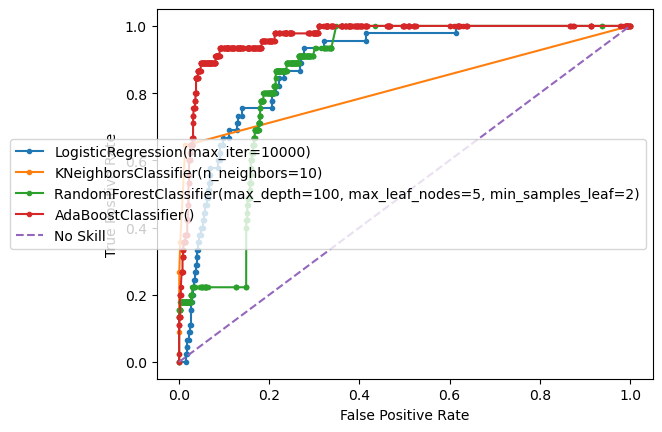

In [180]:
results_no_sample = []
models = [lr, knn, rf, ada]
for m in models:
    m.fit(X_train, y_train.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = metrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_no_sample.append([acc, rec, auc])

    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Epoch 1/50
608/608 [==============================] - 4s 4ms/step - loss: 0.0588 - accuracy: 0.9915 - val_loss: 0.0252 - val_accuracy: 0.9954
Epoch 2/50
608/608 [==============================] - 2s 3ms/step - loss: 0.0232 - accuracy: 0.9960 - val_loss: 0.0272 - val_accuracy: 0.9954
Epoch 3/50
608/608 [==============================] - 2s 3ms/step - loss: 0.0232 - accuracy: 0.9960 - val_loss: 0.0243 - val_accuracy: 0.9954
Epoch 4/50
608/608 [==============================] - 2s 3ms/step - loss: 0.0229 - accuracy: 0.9960 - val_loss: 0.0248 - val_accuracy: 0.9954
Epoch 5/50
608/608 [==============================] - 2s 3ms/step - loss: 0.0225 - accuracy: 0.9960 - val_loss: 0.0246 - val_accuracy: 0.9954
Epoch 6/50
608/608 [==============================] - 2s 3ms/step - loss: 0.0223 - accuracy: 0.9960 - val_loss: 0.0251 - val_accuracy: 0.9954
Epoch 7/50
608/608 [==============================] - 2s 3ms/step - loss: 0.0224 - accuracy: 0.9960 - val_loss: 0.0249 - val_accuracy: 0.9954
Epoch 

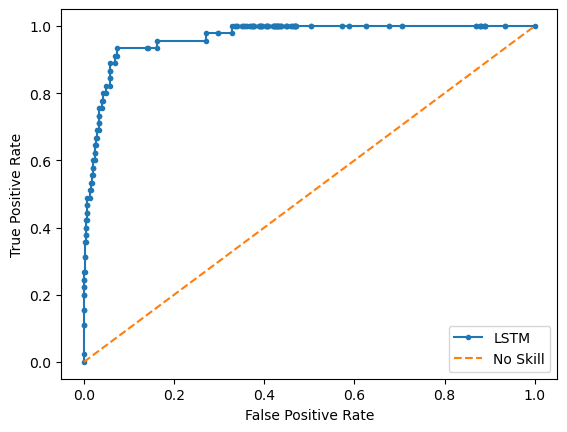

LSTM:
 [[9678    0]
 [  45    0]] 

[[0.9952689499125784, 0.0, 0.49994833643314734], [0.9953717988275224, 0.0, 0.5], [0.9957831944872981, 0.08888888888888889, 0.5444444444444444], [0.98436696492852, 0.35555555555555557, 0.6714231590549012], [0.9953718, 0.0, 0.9265528]]


In [181]:
X_numpy = np.expand_dims(X_train.values[:,:],axis = 2)
y_numpy = y_train.values[:]
X_numpy_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=32, return_sequences=False, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy, y_numpy, epochs=50, batch_size=64, validation_data=(X_numpy_test, y_numpy_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_no_sample.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_no_sample)

# CREATE SAMPLED AND AUGMENTED DATA

In [182]:
final_undersample = RandomUnderSampler(sampling_strategy='majority')
X_final_under, y_final_under = final_undersample.fit_resample(X_train, y_train)
final_under = X_final_under.copy()
final_under['label'] = y_final_under

final_oversample = RandomOverSampler(sampling_strategy='minority')
X_final_over, y_final_over = final_oversample.fit_resample(X_train, y_train)
final_over = X_final_over.copy()
final_over['label'] = y_final_over

final_smote = SMOTE(k_neighbors=5)
X_final_smote, y_final_smote = final_smote.fit_resample(X_train, y_train)
final_smote = X_final_smote.copy()
final_smote['label'] = y_final_smote

final_blsmote = BorderlineSMOTE(k_neighbors=5)
X_final_blsmote, y_final_blsmote = final_blsmote.fit_resample(X_train, y_train)
final_blsmote = X_final_blsmote.copy()
final_blsmote['label'] = y_final_blsmote

final_adasyn = ADASYN(n_neighbors=5)
X_final_adasyn, y_final_adasyn = final_adasyn.fit_resample(X_train, y_train)
final_adasyn = X_final_adasyn.copy()
final_adasyn['label'] = y_final_adasyn

# Undersampling

LogisticRegression(max_iter=10000) 
 [[8690  988]
 [  11   34]] 

KNeighborsClassifier(n_neighbors=10) 
 [[8253 1425]
 [   7   38]] 

RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2) 
 [[8108 1570]
 [   4   41]] 

AdaBoostClassifier() 
 [[7865 1813]
 [   0   45]] 



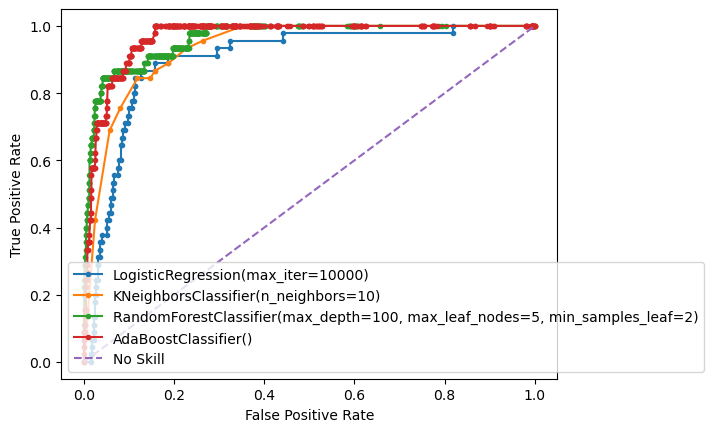

In [183]:
results_under = []
models = [lr, knn, rf, ada]
for m in models:
    m.fit(X_final_under, y_final_under.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = skmetrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_under.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


Epoch 1/25
20/20 [==============================] - 4s 95ms/step - loss: 0.6540 - accuracy: 0.6603 - val_loss: 0.6547 - val_accuracy: 0.6484
Epoch 2/25
20/20 [==============================] - 1s 66ms/step - loss: 0.5926 - accuracy: 0.7051 - val_loss: 0.5663 - val_accuracy: 0.7054
Epoch 3/25
20/20 [==============================] - 1s 66ms/step - loss: 0.5689 - accuracy: 0.7244 - val_loss: 0.5467 - val_accuracy: 0.7494
Epoch 4/25
20/20 [==============================] - 1s 65ms/step - loss: 0.5539 - accuracy: 0.7404 - val_loss: 0.4396 - val_accuracy: 0.7664
Epoch 5/25
20/20 [==============================] - 1s 63ms/step - loss: 0.5490 - accuracy: 0.7692 - val_loss: 0.4463 - val_accuracy: 0.7591
Epoch 6/25
20/20 [==============================] - 1s 62ms/step - loss: 0.5187 - accuracy: 0.7724 - val_loss: 0.4466 - val_accuracy: 0.7464
Epoch 7/25
20/20 [==============================] - 1s 61ms/step - loss: 0.4964 - accuracy: 0.7788 - val_loss: 0.3921 - val_accuracy: 0.7511
Epoch 8/25
20

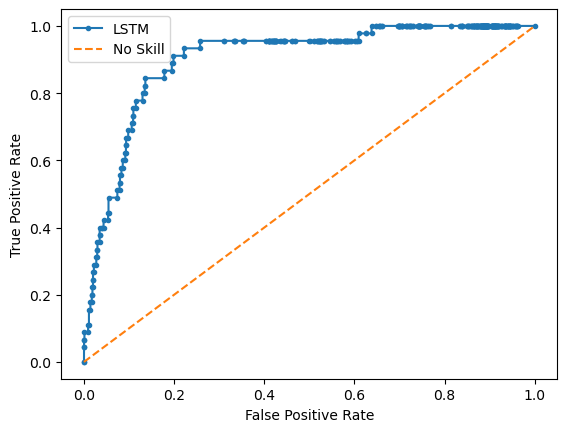

LSTM:
 [[8317 1361]
 [   7   38]] 

[[0.8972539339709966, 0.7555555555555555, 0.8267341737273541], [0.8527203538002674, 0.8444444444444444, 0.8486016394571883], [0.8381158078782269, 0.9111111111111111, 0.8744437555968864], [0.8135349172066235, 1.0, 0.9063339532961356], [0.8593027, 0.84444445, 0.89902306]]


In [184]:
X_numpy_under = np.expand_dims(X_final_under.values[:,:],axis = 2)
y_numpy_under = y_final_under.values[:]
X_numpy_under_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_under_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_under.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_under, y_numpy_under, epochs=25, batch_size=16, validation_data=(X_numpy_under_test, y_numpy_under_test))
ypred = model.predict(X_numpy_under_test).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy_under_test, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy_under_test, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy_under_test, ypred)
auc = bauc.result().numpy()

results_under.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy_under_test, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_under)

# Oversampling

LogisticRegression(max_iter=10000) 
 [[8641 1037]
 [   6   39]] 

KNeighborsClassifier(n_neighbors=10) 
 [[9606   72]
 [  19   26]] 

RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2) 
 [[8154 1524]
 [   4   41]] 

AdaBoostClassifier() 
 [[8872  806]
 [   4   41]] 



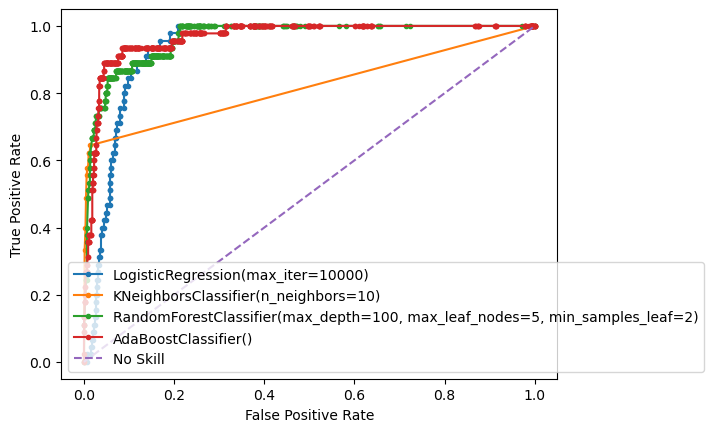

In [185]:
results_over = []
models = [lr, knn, rf, ada]
for m in models:
    m.fit(X_final_over, y_final_over.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = skmetrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_over.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Epoch 1/25
1211/1211 [==============================] - 16s 11ms/step - loss: 0.3595 - accuracy: 0.8574 - val_loss: 0.3287 - val_accuracy: 0.8818
Epoch 2/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.2634 - accuracy: 0.9109 - val_loss: 0.2044 - val_accuracy: 0.9268
Epoch 3/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.2203 - accuracy: 0.9293 - val_loss: 0.2368 - val_accuracy: 0.9137
Epoch 4/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.1716 - accuracy: 0.9409 - val_loss: 0.1896 - val_accuracy: 0.9247
Epoch 5/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.1237 - accuracy: 0.9579 - val_loss: 0.1204 - val_accuracy: 0.9512
Epoch 6/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.0970 - accuracy: 0.9695 - val_loss: 0.1285 - val_accuracy: 0.9538
Epoch 7/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.0819 - accuracy: 0.9746 - val_loss: 0.0972 -

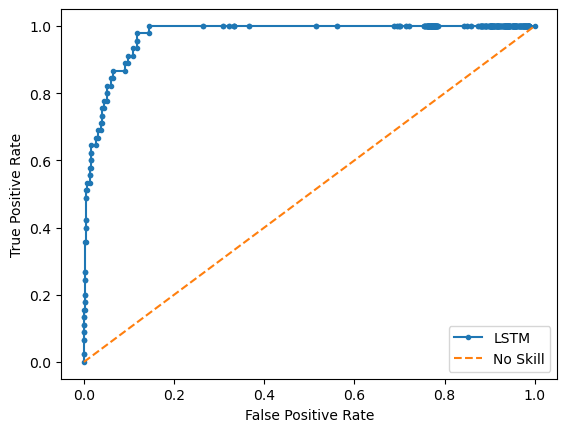

LSTM:
 [[9549  129]
 [  20   25]] 

[[0.8927285817134629, 0.8666666666666667, 0.8797582145071295], [0.9906407487401008, 0.5777777777777777, 0.7851691120754977], [0.8428468579656485, 0.9111111111111111, 0.8768202796721085], [0.9166923788954027, 0.9111111111111111, 0.9139147206723152], [0.9846755, 0.5555556, 0.8754082]]


In [186]:
X_numpy_over = np.expand_dims(X_final_over.values[:,:],axis = 2)
y_numpy_over = y_final_over.values[:]
X_numpy_over_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_over_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_over.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_over, y_numpy_over, epochs=25, batch_size=64, validation_data=(X_numpy_over_test, y_numpy_over_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_over.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_over)

# Hybrid

In [139]:
final_oversample_1 = RandomOverSampler(sampling_strategy=0.3)
X_final_over_1, y_final_over_1 = final_oversample_1.fit_resample(X_train, y_train)
X_final_ou, y_final_ou = final_undersample.fit_resample(X_final_over_1, y_final_over_1)

In [140]:
print("Number of malicious records: ", y_final_ou.value_counts()[1])
print("Number of normal records: ", y_final_ou.value_counts()[0])

Number of malicious records:  3899
Number of normal records:  3899


LogisticRegression(max_iter=10000) 
 [[2729  527]
 [   1    9]] 

SVC(probability=True) 
 [[3009  247]
 [   1    9]] 

KNeighborsClassifier(n_neighbors=10) 
 [[3158   98]
 [   3    7]] 

RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2) 
 [[2960  296]
 [   1    9]] 

AdaBoostClassifier() 
 [[3145  111]
 [   0   10]] 



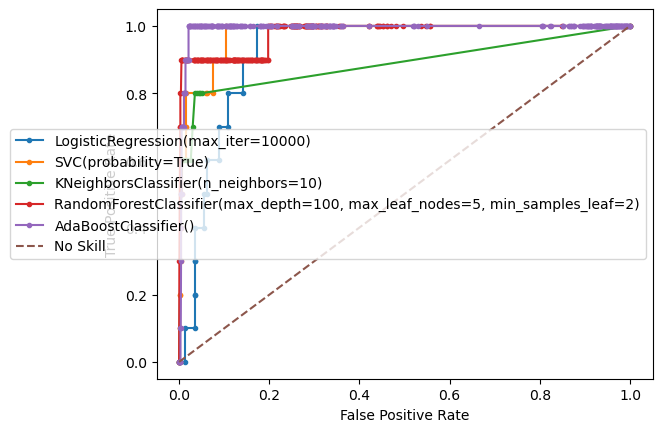

In [141]:
results_ou = []
models = [lr, svm, knn, rf, ada]
for m in models:
    m.fit(X_final_ou, y_final_ou.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = skmetrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_ou.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot

Epoch 1/25
122/122 [==============================] - 4s 16ms/step - loss: 0.5075 - accuracy: 0.7593 - val_loss: 0.4524 - val_accuracy: 0.7535
Epoch 2/25
122/122 [==============================] - 1s 12ms/step - loss: 0.4250 - accuracy: 0.8044 - val_loss: 0.8873 - val_accuracy: 0.5992
Epoch 3/25
122/122 [==============================] - 1s 12ms/step - loss: 0.3810 - accuracy: 0.8318 - val_loss: 0.3907 - val_accuracy: 0.8408
Epoch 4/25
122/122 [==============================] - 1s 11ms/step - loss: 0.3306 - accuracy: 0.8597 - val_loss: 0.3142 - val_accuracy: 0.8393
Epoch 5/25
122/122 [==============================] - 1s 12ms/step - loss: 0.3139 - accuracy: 0.8657 - val_loss: 0.2832 - val_accuracy: 0.8631
Epoch 6/25
122/122 [==============================] - 1s 12ms/step - loss: 0.3032 - accuracy: 0.8700 - val_loss: 0.3598 - val_accuracy: 0.8411
Epoch 7/25
122/122 [==============================] - 1s 12ms/step - loss: 0.2968 - accuracy: 0.8733 - val_loss: 0.2711 - val_accuracy: 0.8585

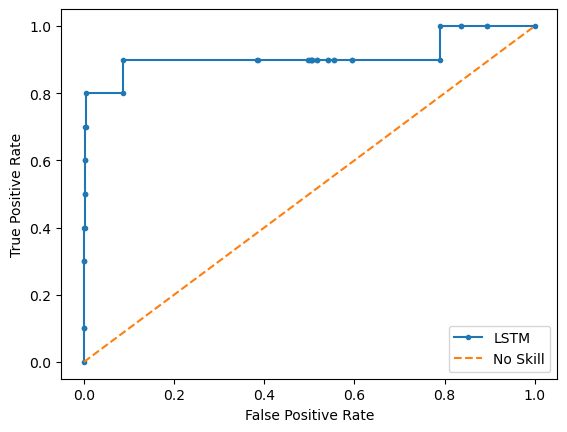

LSTM:
 [[3024  232]
 [   2    8]] 

[[0.8383343539497856, 0.9, 0.8690724815724815], [0.9240661359461114, 0.9, 0.9120700245700245], [0.9690753214941825, 0.7, 0.8349508599508599], [0.9090630740967545, 0.9, 0.9045454545454544], [0.9660134721371708, 1.0, 0.9829545454545455], [0.9283527, 0.8, 0.92584467]]


In [142]:
X_numpy_ou = np.expand_dims(X_final_ou.values[:,:],axis = 2)
y_numpy_ou = y_final_ou.values[:]
X_numpy_ou_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_ou_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_over.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_ou, y_numpy_ou, epochs=25, batch_size=64, validation_data=(X_numpy_ou_test, y_numpy_ou_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_ou.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_ou)

# SMOTE

LogisticRegression(max_iter=10000) 
 [[2776  480]
 [   1    9]] 

KNeighborsClassifier(n_neighbors=10) 
 [[3194   62]
 [   2    8]] 

RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2) 
 [[ 740 2516]
 [   0   10]] 

AdaBoostClassifier() 
 [[2541  715]
 [   0   10]] 



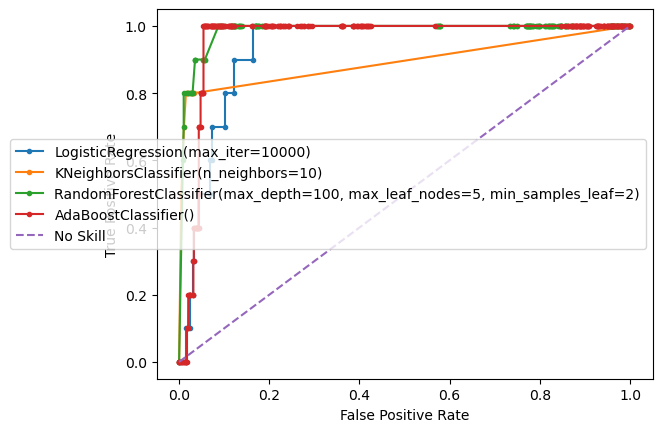

In [143]:
results_smote = []
models = [lr, knn, rf, ada]

for m in models:
    m.fit(X_final_smote, y_final_smote.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_smote.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Epoch 1/25
122/122 [==============================] - 5s 16ms/step - loss: 0.5084 - accuracy: 0.7556 - val_loss: 0.4681 - val_accuracy: 0.7376
Epoch 2/25
122/122 [==============================] - 1s 12ms/step - loss: 0.4240 - accuracy: 0.8053 - val_loss: 0.4870 - val_accuracy: 0.7024
Epoch 3/25
122/122 [==============================] - 1s 12ms/step - loss: 0.3764 - accuracy: 0.8368 - val_loss: 0.3397 - val_accuracy: 0.8469
Epoch 4/25
122/122 [==============================] - 1s 11ms/step - loss: 0.3320 - accuracy: 0.8625 - val_loss: 0.4104 - val_accuracy: 0.8264
Epoch 5/25
122/122 [==============================] - 1s 12ms/step - loss: 0.3178 - accuracy: 0.8648 - val_loss: 0.3386 - val_accuracy: 0.8408
Epoch 6/25
122/122 [==============================] - 2s 12ms/step - loss: 0.3068 - accuracy: 0.8684 - val_loss: 0.4235 - val_accuracy: 0.8043
Epoch 7/25
122/122 [==============================] - 2s 14ms/step - loss: 0.2948 - accuracy: 0.8725 - val_loss: 0.3894 - val_accuracy: 0.8423

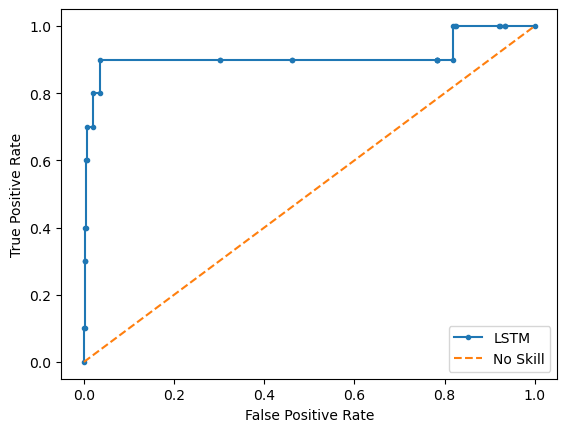

LSTM:
 [[3036  220]
 [   1    9]] 

[[0.8383343539497856, 0.9, 0.8690724815724815], [0.9240661359461114, 0.9, 0.9120700245700245], [0.9690753214941825, 0.7, 0.8349508599508599], [0.9090630740967545, 0.9, 0.9045454545454544], [0.9660134721371708, 1.0, 0.9829545454545455], [0.9283527, 0.8, 0.92584467]]


In [144]:
X_numpy_smote = np.expand_dims(X_final_smote.values[:,:],axis = 2)
y_numpy_smote = y_final_smote.values[:]
X_numpy_smote_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_smote_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_smote.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_ou, y_numpy_ou, epochs=25, batch_size=64, validation_data=(X_numpy_ou_test, y_numpy_ou_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_smote.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_ou)

# ADASYN

In [79]:
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_final_adasyn, y_final_adasyn, test_size=0.3)

In [ ]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("logistic regression best: ", grid.best_estimator_)
# ada_lr_best_est = grid.best_estimator_



In [ ]:

# #linear failed to converge
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("SVM best: ", grid.best_estimator_)
# ada_svm_best_est = grid.best_estimator_



In [ ]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("KNN best: ", grid.best_estimator_)
# ada_knn_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn, y_train_adasyn.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# print("RF Best score:", grid.best_score_)
# ada_rf_best_est = grid.best_estimator_


In [ ]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn, y_train_adasyn.values.ravel())
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# print("ADA Best score:", grid.best_score_)
# ada_ada_best_est = grid.best_estimator_

In [ ]:
# #Adapt from above
# lr = ada_lr_best_est
# svm = ada_svm_best_est
# knn = ada_knn_best_est
# rf = ada_rf_best_est
# ada = ada_ada_best_est


In [80]:
results_adasyn = []
models = [lr, svm, knn, rf, ada]

for m in models:
    m.fit(X_train_adasyn, y_train_adasyn.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    results_adasyn.append([acc, rec, prec, f1, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

X_numpy_adasyn = np.expand_dims(X_train_adasyn.values[:,:],axis = 2)
y_numpy_adasyn = y_train_adasyn.values[:]
X_numpy_adasyn_test = np.expand_dims(X_test_adasyn.values[:,:],axis = 2)
y_numpy_adasyn_test = y_test_adasyn.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_adasyn.append([acc, rec, prec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_adasyn)

AttributeError: module 'keras.metrics.metrics' has no attribute 'accuracy_score'

# Borderline SMOTE

In [ ]:
X_train_blsmote, X_test_blsmote, y_train_blsmote, y_test_blsmote = train_test_split(X_final_blsmote, y_final_blsmote, test_size=0.3)

In [ ]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("logistic regression best: ", grid.best_estimator_)
# bls_lr_best_est = grid.best_estimator_



In [ ]:

# #linear failed to converge
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("SVM best: ", grid.best_estimator_)
# bls_svm_best_est = grid.best_estimator_

In [ ]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("KNN best: ", grid.best_estimator_)
# bls_knn_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote, y_train_blsmote.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# print("RF Best score:", grid.best_score_)
# bls_rf_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote, y_train_blsmote)
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# print("ADA Best score:", grid.best_score_)
# bls_ada_best_est = grid.best_estimator_

In [ ]:
# #Adapt from above
# lr = LogisticRegression(max_iter=1000)
# svm = SVC(probability=True)
# knn = bls_knn_best_est
# rf = bls_rf_best_est
# ada = bls_ada_best_est

In [ ]:
results_blsmote = []
models = [lr, svm, knn, rf, ada]

for m in models:
    m.fit(X_train_blsmote, y_train_blsmote.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    results_blsmote.append([acc, rec, prec, f1, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

X_numpy_blsmote = np.expand_dims(X_train_blsmote.values[:,:],axis = 2)
y_numpy_blsmote = y_train_blsmote.values[:]
X_numpy_blsmote_test = np.expand_dims(X_test_blsmote.values[:,:],axis = 2)
y_numpy_blsmote_test = y_test_blsmote.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_blsmote.append([acc, rec, prec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_blsmote)

In [ ]:
# sb.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

EXPERIMENT SECTION

In [ ]:
param_grid = {
     'n_estimators': [100, 200, 300],
     'learning_rate': [0.01, 0.05, 0.1, 1],
     'algorithm': ['SAMME', 'SAMME.R']
 }
grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
grid.fit(X_final_under, y_final_under.values.ravel())
print("ADA Best estimater:", grid.best_estimator_)
print("ADA Best parameters:", grid.best_params_)
print("ADA Best score:", grid.best_score_)
ada_ada_best_est = grid.best_estimator_
ada = ada_ada_best_est

results_under = pd.DataFrame(columns=['model', 'acc', 'rec', 'auc'])
for e in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # X_test.drop(columns=[10000], inplace=True)
    # X_train.drop(columns=[10000], inplace=True)

    X_test.drop(columns=[10000, 10007, 10009, 10011, 10012, 10008, 10010], inplace=True)
    X_train.drop(columns=[10000, 10007, 10009, 10011, 10012, 10008, 10010], inplace=True)

    # X_test = X_test[[10007, 10009, 10011, 10012, 10008, 10010]]
    # X_train = X_train[[10007, 10009, 10011, 10012, 10008, 10010]]

    # X_test.drop(columns=[10000, 10007, 10009, 10011, 10012], inplace=True)
    # X_train.drop(columns=[10000, 10007, 10009, 10011, 10012], inplace=True)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    final_undersample = RandomUnderSampler(sampling_strategy='majority')
    X_final_under, y_final_under = final_undersample.fit_resample(X_train, y_train)
    final_under = X_final_under.copy()
    final_under['label'] = y_final_under

    final_oversample = RandomOverSampler(sampling_strategy='minority')
    X_final_over, y_final_over = final_oversample.fit_resample(X_train, y_train)
    final_over = X_final_over.copy()
    final_over['label'] = y_final_over

    final_smote = SMOTE(k_neighbors=10)
    X_final_smote, y_final_smote = final_smote.fit_resample(X_train, y_train)
    final_smote = X_final_smote.copy()
    final_smote['label'] = y_final_smote

    final_blsmote = BorderlineSMOTE(k_neighbors=10)
    X_final_blsmote, y_final_blsmote = final_blsmote.fit_resample(X_train, y_train)
    final_blsmote = X_final_blsmote.copy()
    final_blsmote['label'] = y_final_blsmote

    final_adasyn = ADASYN(n_neighbors=10)
    X_final_adasyn, y_final_adasyn = final_adasyn.fit_resample(X_train, y_train)
    final_adasyn = X_final_adasyn.copy()
    final_adasyn['label'] = y_final_adasyn

    models = [lr, knn, rf, ada]
    for m in models:
        m.fit(X_final_under, y_final_under.values.ravel())
        predicted = m.predict(X_test)
        acc = skmetrics.accuracy_score(y_test, predicted)
        rec = skmetrics.recall_score(y_test, predicted)
        auc = skmetrics.roc_auc_score(y_test, predicted)
        results_under.loc[len(results_under.index)] = [m, acc, rec, auc] 


    X_numpy_under = np.expand_dims(X_final_under.values[:,:],axis = 2)
    y_numpy_under = y_final_under.values[:]
    X_numpy_under_test = np.expand_dims(X_test.values[:,:],axis = 2)
    y_numpy_under_test = y_test.values[:]
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_under.columns), 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    model.fit(X_numpy_under, y_numpy_under, epochs=10, batch_size=16, validation_data=(X_numpy_under_test, y_numpy_under_test))
    ypred = model.predict(X_numpy_under_test).ravel()

    ba = tf.keras.metrics.BinaryAccuracy()
    ba.update_state(y_numpy_under_test, ypred)
    acc = ba.result().numpy()

    br = tf.keras.metrics.Recall()
    br.update_state(y_numpy_under_test, ypred)
    rec = br.result().numpy()

    bauc = tf.keras.metrics.AUC()
    bauc.update_state(y_numpy_under_test, ypred)
    auc = bauc.result().numpy()

    results_under.loc[len(results_under.index)] = ['lstm', acc, rec, auc] 
    results_under

results_under.to_excel("/Users/ken.clements/Desktop/results6.xlsx")